## Search for anomalies

A colleague from the London office sent you data for two years: from January 4, 2015 to January 3, 2017. You will study the dynamics of the number of rentals, the relationship with weather conditions and holidays, and also explain several anomalies in the graph.

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

In [2]:
df = pd.read_csv('london.csv', parse_dates=['timestamp'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     17414 non-null  datetime64[ns]
 1   cnt           17414 non-null  int64         
 2   t1            17414 non-null  float64       
 3   t2            17414 non-null  float64       
 4   hum           17414 non-null  float64       
 5   wind_speed    17414 non-null  float64       
 6   weather_code  17414 non-null  float64       
 7   is_holiday    17414 non-null  float64       
 8   is_weekend    17414 non-null  float64       
 9   season        17414 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 1.3 MB


In [4]:
df.isna().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

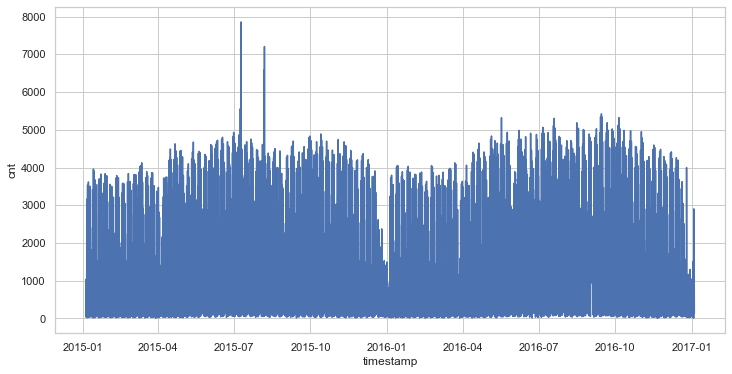

In [9]:
sns.lineplot(x=df.timestamp, y=df.cnt);

In [10]:
df = df.set_index('timestamp')

Let's aggregate the number of trips by day and visualize the result.  

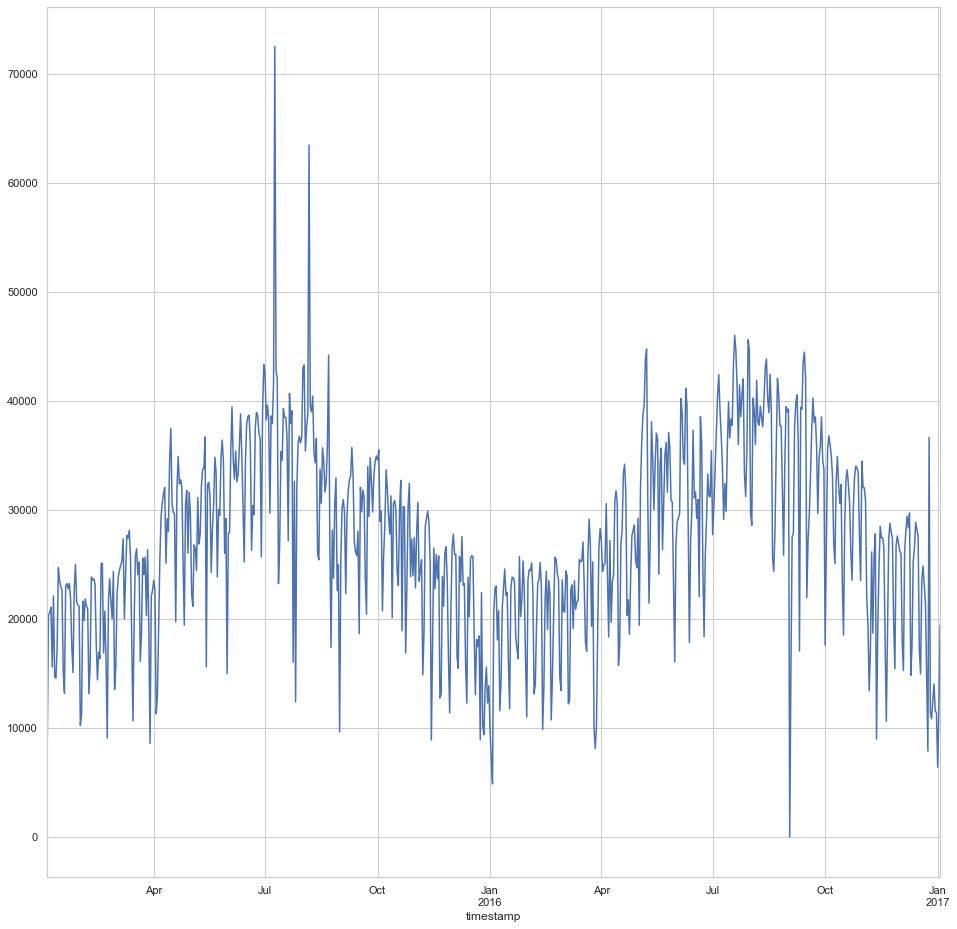

In [11]:
plt.figure(figsize=(16,16))
df.resample(rule='D').cnt.sum().plot();

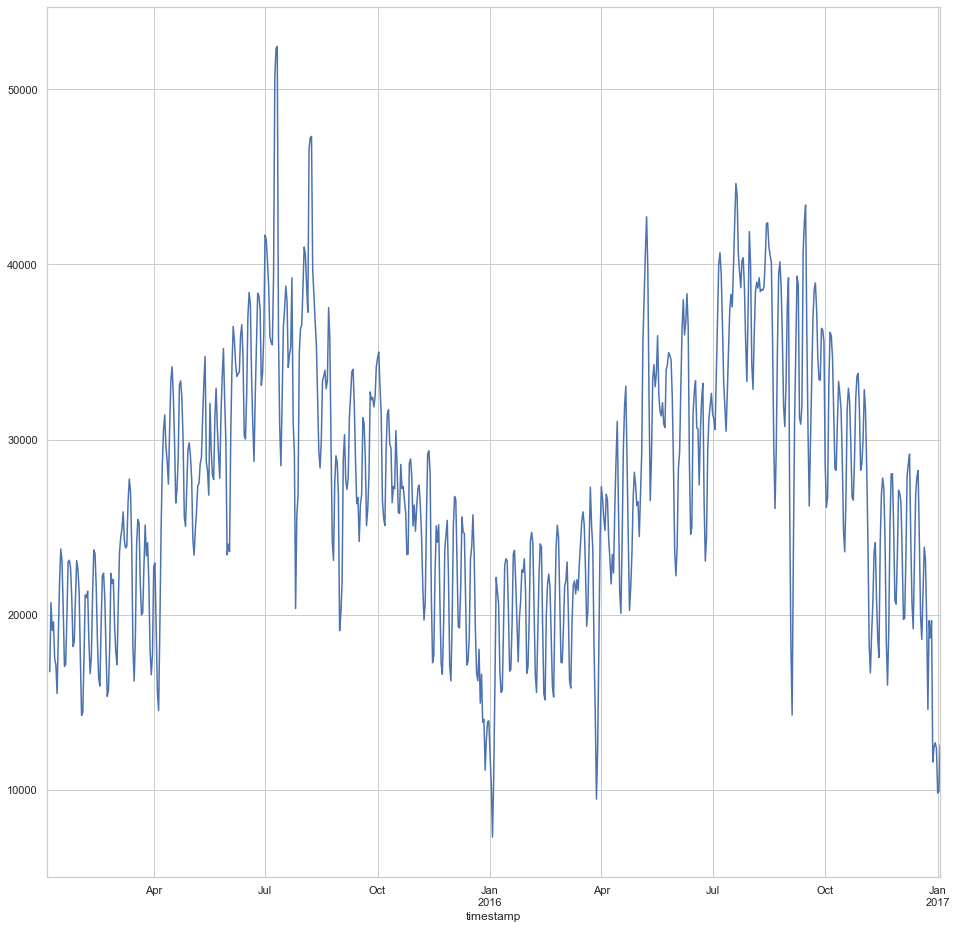

In [12]:
plt.figure(figsize=(16,16))
df.resample(rule='D').cnt.sum().rolling(3).mean().plot();

In winter, the number of rentals is less than in summer  
There are both very sharp jumps in the number of rentals, and falls  
The maximum number of rentals per day is more than 70,000  

In [14]:
#aggregate data by day
df_1 = df.resample(rule='D').cnt.sum().reset_index()

In [15]:
#calculate the moving average with a window of 3
df_1['rolling'] = df_1.cnt.rolling(3).mean()

In [16]:
#calculate the difference between observed and counted values
df_1['diff'] = df_1.cnt - df_1['rolling']

In [19]:
#standard deviation calculation
df_1['std'] = np.std(df_1['diff'])

In [21]:
df_1.head()

,timestamp,cnt,rolling,diff,std
0,2015-01-04,9234,NaN,NaN,4558.586641
1,2015-01-05,20372,NaN,NaN,4558.586641
2,2015-01-06,20613,16739.666667,3873.333333,4558.586641
3,2015-01-07,21064,20683.000000,381.000000,4558.586641
4,2015-01-08,15601,19092.666667,-3491.666667,4558.586641


Let's define the boundaries of the confidence interval.

In [22]:
df_1['upper_bound'] = df_1['rolling']+df_1['std']*2.576

In [23]:
df_1['lower_bound'] = df_1['rolling']-df_1['std']*2.576

In [25]:
df_1.head()

,timestamp,cnt,rolling,diff,std,upper_bound,lower_bound
0,2015-01-04,9234,NaN,NaN,4558.586641,NaN,NaN
1,2015-01-05,20372,NaN,NaN,4558.586641,NaN,NaN
2,2015-01-06,20613,16739.666667,3873.333333,4558.586641,28482.585854,4996.747479
3,2015-01-07,21064,20683.000000,381.000000,4558.586641,32425.919188,8940.080812
4,2015-01-08,15601,19092.666667,-3491.666667,4558.586641,30835.585854,7349.747479


And finally - let's study the abnormally high values! First, print out the cases for which the observed values are greater than the upper bound of the 99% confidence interval.

In [26]:
df_1.query('cnt > upper_bound').sort_values('cnt')

,timestamp,cnt,rolling,diff,std,upper_bound,lower_bound
609,2016-09-04,27512,14259.000000,13253.000000,4558.586641,26001.919188,2516.080812
721,2016-12-25,36653,19650.666667,17002.333333,4558.586641,31393.585854,7907.747479
214,2015-08-06,63468,46627.333333,16840.666667,4558.586641,58370.252521,34884.414146
186,2015-07-09,72504,50705.000000,21799.000000,4558.586641,62447.919188,38962.080812


the reason for the high number of rentals 2015-07-09 - Strikes in the subway

In [27]:
df_1.query('cnt < lower_bound').sort_values('cnt')

,timestamp,cnt,rolling,diff,std,upper_bound,lower_bound
607,2016-09-02,0,26086.333333,-26086.333333,4558.586641,37829.252521,14343.414146
314,2015-11-14,8898,21037.333333,-12139.333333,4558.586641,32780.252521,9294.414146
678,2016-11-12,8990,20878.000000,-11888.000000,4558.586641,32620.919188,9135.080812
130,2015-05-14,15609,28709.333333,-13100.333333,4558.586641,40452.252521,16966.414146
201,2015-07-24,16034,31013.666667,-14979.666667,4558.586641,42756.585854,19270.747479
615,2016-09-10,17080,31262.000000,-14182.000000,4558.586641,43004.919188,19519.080812
232,2015-08-24,17400,29529.333333,-12129.333333,4558.586641,41272.252521,17786.414146
621,2016-09-16,21967,36193.333333,-14226.333333,4558.586641,47936.252521,24450.414146
189,2015-07-12,23240,36036.666667,-12796.666667,4558.586641,47779.585854,24293.747479


the reason for the fall in the number of rentals 2016-09-02 - Data collection error